<a href="https://colab.research.google.com/github/sayaka71/deep-learning/blob/master/%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98%E3%83%AC%E3%82%B7%E3%83%945_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlowで転移学習(retrain)
[チュートリアル](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

In [12]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 102kB 3.9MB/s 


#ImageNetの分類基

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

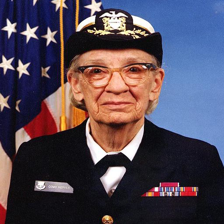

In [17]:
# 試してみる
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
grace_hopper

array([[[0.09803922, 0.10980392, 0.32156863],
        [0.11372549, 0.12156863, 0.35686275],
        [0.10588235, 0.10980392, 0.37254902],
        ...,
        [0.28627451, 0.43529412, 0.7254902 ],
        [0.27058824, 0.41960784, 0.71372549],
        [0.2745098 , 0.42352941, 0.71764706]],

       [[0.10980392, 0.12156863, 0.33333333],
        [0.10588235, 0.11372549, 0.35294118],
        [0.10588235, 0.10980392, 0.36862745],
        ...,
        [0.30196078, 0.44705882, 0.73333333],
        [0.31764706, 0.4627451 , 0.74901961],
        [0.31372549, 0.45882353, 0.74509804]],

       [[0.10588235, 0.11764706, 0.32941176],
        [0.10980392, 0.11764706, 0.35294118],
        [0.11764706, 0.12156863, 0.38039216],
        ...,
        [0.33333333, 0.4745098 , 0.75294118],
        [0.31372549, 0.45882353, 0.7372549 ],
        [0.3254902 , 0.47058824, 0.74901961]],

       ...,

       [[0.62745098, 0.03921569, 0.09019608],
        [0.63137255, 0.05490196, 0.09411765],
        [0.59215686, 0

In [20]:
# 画像をモデルに入力
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [21]:
# 1000classのなかで一番確率が高いもの
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [22]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


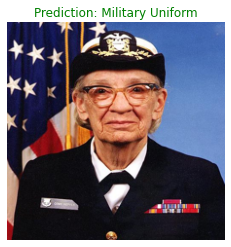

In [27]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title(), c='g')

In [0]:
# retrain

In [29]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [30]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [31]:
# image_batch & label_batchを返すエテレーター
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [32]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [33]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['head cabbage', 'fountain', 'cardoon', 'hay', 'dining table',
       'rapeseed', 'bee', 'daisy', 'picket fence', 'daisy', 'bee',
       'sea urchin', 'coral fungus', 'cardoon', 'hamper', 'daisy',
       'crane', 'balloon', 'picket fence', 'bee', 'nail', 'knot',
       'sea urchin', 'bee', 'balloon', 'coral fungus', 'daisy', 'daisy',
       'hummingbird', 'picket fence', 'sea urchin', 'lifeboat'],
      dtype='<U30')

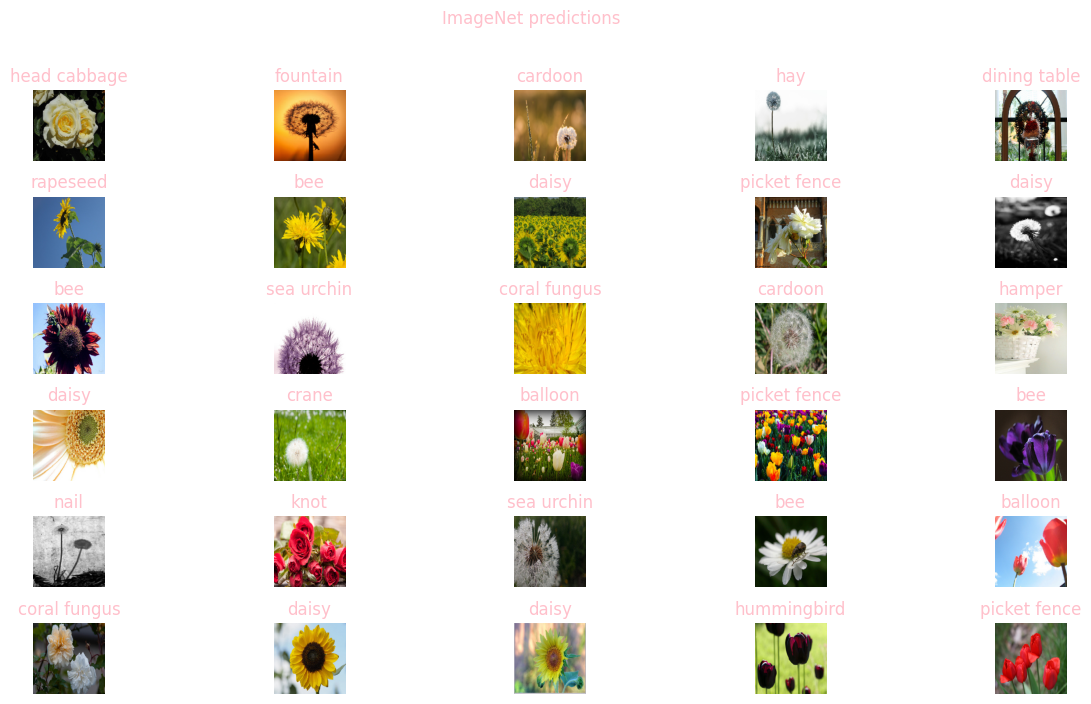

In [40]:
plt.figure(figsize=(15,8), dpi=100)
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n], c='pink')
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions", c='pink')

In [0]:
# ヘッドレスモデルのダウンロード
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [43]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [45]:
# 上の分類そうを結合
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [0]:
# train model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [49]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 14s 118ms/step - loss: 0.2662 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 13s 117ms/step - loss: 0.2721 - acc: 0.9375


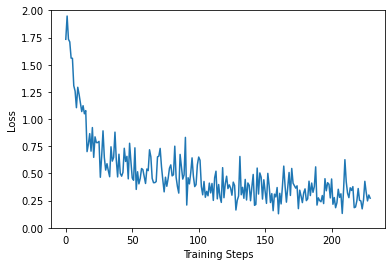

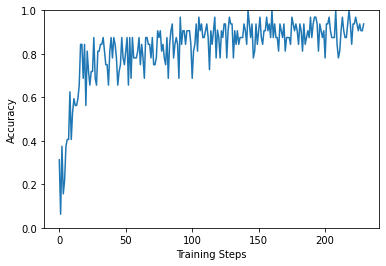

In [50]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [59]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

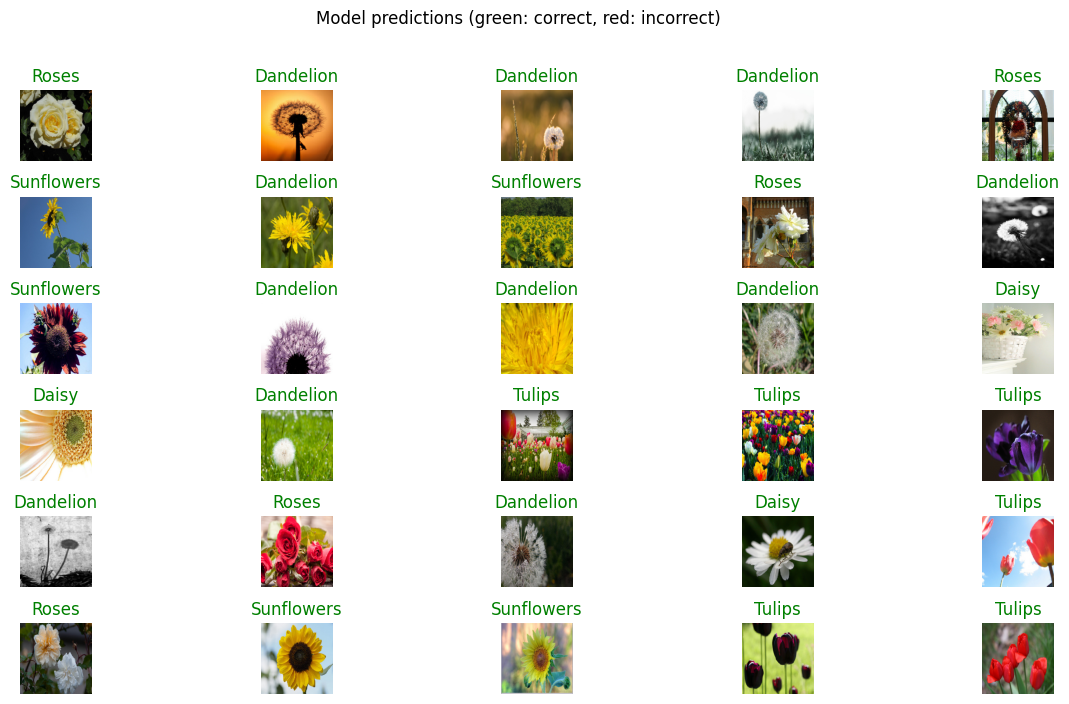

In [62]:
plt.figure(figsize=(15,8), dpi=100)
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])

  if predicted_id[n] == label_id[n]:
    color='green'
  else:
     color="red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [63]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1590202749/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1590202749/assets


'/tmp/saved_models/1590202749'

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [66]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [67]:
ls

flower_photos.tgz  retrain.py  sample_data/
